In [18]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt

### Initial state initialyzing

In [19]:
n, l = 3, 4 # количество видов узлов и возможных взаимодействий между ними
alpha_0 = np.array([100, 4, 0]) # уязвимые, заражённые, невосприимчивые, лекарство
alpha = alpha_0.copy()
N = sum(alpha_0)
Vs = N // 2 - 1 # скорость сканирования ip4 адресов вирусом [узел/сек]
lmb = 0.02 # интенсивность потока заражения [скорость * кол-во узлов / размер адресного пространства]
imm = lmb * 5 # интенсивность потока лечения заражения
a = lmb * 100 # интенсивность потока добавления новых узлов в компьютерную сеть
eps = np.array([[1, 1, 0], #заражение
                [0, 1, 0], # лечение заражённого
                [1, 0, 0], # иммунизация уязвимого
                [0, 0, 0]]) # добавление нового узла
phi = np.array([lmb*alpha_0[0]*alpha_0[1], imm*alpha_0[1], imm*alpha_0[0], a]) # интенсивности потоков, учитывая количество частиц
p_gamma = np.array([[0, 2, 0], # два заражённых
                    [0, 0, 1], # новый неуязвимый
                    [0, 0, 1], # новый неуязвимый
                    [1, 0, 0]]) # новый уязвимый

In [ ]:
print("eps:", eps)
print("phi:", phi)
print("p_gamma:", p_gamma)

### Process

In [20]:
def inverse_exp(random_, coef):
    '''возвращает значение случайной величины,
    распределённой по экспоненциальному закону,
    соответствующему простейшему Пуассоновскому потоку'''
    if coef == 0:
        return np.finfo(np.float32).max
    return -1/coef * math.log(1 - random_)
    #return 1/coef

def inverse_exp_det(coef):
    '''возвращает значение случайной величины,
    распределённой по экспоненциальному закону,
    соответствующему простейшему Пуассоновскому потоку'''
    if coef == 0:
        return np.finfo(np.float32).max
    return 1/coef

tau = np.array([0 for _ in range(l)], dtype=np.float32) # время следующего события i
for i in range(l):
    tau[i] = inverse_exp(random.random(), phi[i])

def update_tau(tau, ):
    ''' Возвращает матрицу с временами событий на следующем шаге и ближайшее событие
    :param tau: array of trigger times, generated on the previous step
    :return: times array on the next step, next event, time of next event'''
    min_ = np.finfo(np.float32).max
    idx_min = 0

    for k in range(len(tau)):
        if tau[k] == np.finfo(np.float32).max and phi[k] != 0:
            tau[k] = inverse_exp(random.random(), phi[k])
        if tau[k] < min_:
            min_ = tau[k]
            idx_min = k
    tau -= min_
    return tau, idx_min, min_

def update_tau_det(tau, ):
    ''' Возвращает матрицу с временами событий на следующем шаге и ближайшее событие
    :param tau: array of trigger times, generated on the previous step
    :return: times array on the next step, next event, time of next event'''
    min_ = np.finfo(np.float32).max
    idx_min = 0

    for k in range(len(tau)):
        if tau[k] == np.finfo(np.float32).max and phi[k] != 0:
            tau[k] = inverse_exp_det(phi[k])
        if tau[k] < min_:
            min_ = tau[k]
            idx_min = k
    tau -= min_
    return tau, idx_min, min_

def update_phi(alpha):
    phi = np.array([lmb*alpha[0]*alpha[1], imm*alpha[1], imm*alpha[0], a])
    phi[~np.all(eps <= alpha, axis=1)] = 0
    return phi

def taking_action(alpha, next_event):
    """Совершаем следующее предопределённое действие
    :param alpha: array of existing particles
    :param next_event: next event with prerequisites from eps and consequences determined from p_gamma
    :return: next state and new probabilities of events"""
    alpha += -eps[next_event] + p_gamma[next_event]
    phi = update_phi(alpha)
    return alpha, phi


### Running K steps

In [21]:
k = 200
particles_history = np.empty((k + 1, n))
times = np.empty(k + 1)
particles_history[0, :] = alpha
times[0] = 0
print(alpha)
for i in range(1, k + 1):
    tau, next_event, delta_time = update_tau(tau)
    alpha, phi = taking_action(alpha, next_event)
    tau[next_event] = inverse_exp(random.random(), phi[next_event])
    particles_history[i, :] = alpha
    times[i] = delta_time + times[i - 1]
    print(f"after {i} step:")
    print("tau:", tau, "\nphi:", phi, "\nalpha:", alpha, "\nevent:", next_event)


[100   4   0]
after 1 step:
tau: [0.01710158 2.3815129  0.0118296  0.20205201] 
phi: [9.9 0.5 9.9 2. ] 
alpha: [99  5  0] 
event: 0
after 2 step:
tau: [0.00527198 2.3696833  0.42971295 0.19022241] 
phi: [9.8 0.5 9.8 2. ] 
alpha: [98  5  1] 
event: 2
after 3 step:
tau: [0.07073547 2.3644114  0.42444098 0.18495043] 
phi: [11.64  0.6   9.7   2.  ] 
alpha: [97  6  1] 
event: 0
after 4 step:
tau: [0.0093497  2.293676   0.35370553 0.11421496] 
phi: [13.44  0.7   9.6   2.  ] 
alpha: [96  7  1] 
event: 0
after 5 step:
tau: [0.11331113 2.284326   0.34435582 0.10486525] 
phi: [15.2  0.8  9.5  2. ] 
alpha: [95  8  1] 
event: 0
after 6 step:
tau: [0.00844588 2.1794608  0.23949057 0.09252624] 
phi: [15.36  0.8   9.6   2.  ] 
alpha: [96  8  1] 
event: 3
after 7 step:
tau: [0.04487776 2.1710148  0.23104468 0.08408036] 
phi: [17.1  0.9  9.5  2. ] 
alpha: [95  9  1] 
event: 0
after 8 step:
tau: [0.07846171 2.126137   0.18616693 0.0392026 ] 
phi: [18.8  1.   9.4  2. ] 
alpha: [94 10  1] 
event: 0
after 

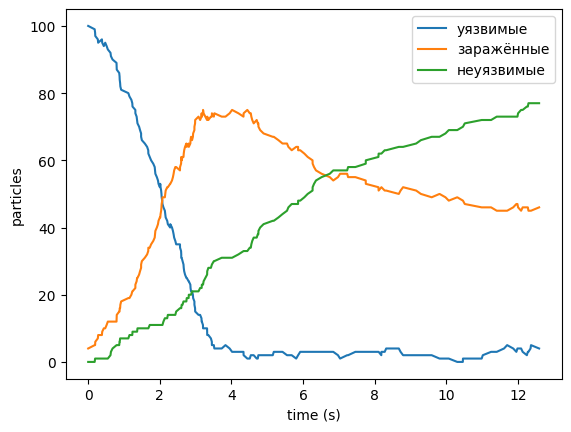

In [22]:
states = ["уязвимые", "заражённые", "неуязвимые"]
def plot_particles_history(particles_history, times):
    for i in range(n):
        plt.plot(times, particles_history[:, i], label=f"{states[i]}")
    plt.xlabel("time (s)")
    plt.ylabel("particles")
    plt.legend()
    plt.show()

plot_particles_history(particles_history, times)

### Determinated process

In [23]:
k = 400
particles_history = np.empty((k + 1, n))
times = np.empty(k + 1)
particles_history[0, :] = alpha_0

alpha = alpha_0.copy()

phi = update_phi(alpha)

tau = np.array([0 for _ in range(l)], dtype=np.float32) # время следующего события i
for i in range(l):
    tau[i] = inverse_exp_det(phi[i])

times[0] = 0
print(alpha_0)
for i in range(1, k + 1):
    tau, next_event, delta_time = update_tau_det(tau)
    alpha, phi = taking_action(alpha, next_event)
    tau[next_event] = inverse_exp_det(phi[next_event])
    particles_history[i, :] = alpha
    times[i] = delta_time + times[i - 1]
    print(f"after {i} step:")
    print("tau:", tau, "\nphi:", phi, "\nalpha:", alpha, "\nevent:", next_event)

[100   4   0]
after 1 step:
tau: [0.025     2.4       0.1010101 0.4      ] 
phi: [7.92 0.4  9.9  2.  ] 
alpha: [99  4  1] 
event: 2
after 2 step:
tau: [0.10204082 2.375      0.0760101  0.375     ] 
phi: [9.8 0.5 9.8 2. ] 
alpha: [98  5  1] 
event: 0
after 3 step:
tau: [0.02603072 2.29899    0.10309278 0.2989899 ] 
phi: [9.7 0.5 9.7 2. ] 
alpha: [97  5  2] 
event: 2
after 4 step:
tau: [0.08680555 2.2729592  0.07706206 0.27295917] 
phi: [11.52  0.6   9.6   2.  ] 
alpha: [96  6  2] 
event: 0
after 5 step:
tau: [0.00974349 2.195897   0.10526316 0.1958971 ] 
phi: [11.4  0.6  9.5  2. ] 
alpha: [95  6  3] 
event: 2
after 6 step:
tau: [0.07598785 2.1861537  0.09551967 0.18615362] 
phi: [13.16  0.7   9.4   2.  ] 
alpha: [94  7  3] 
event: 0
after 7 step:
tau: [0.0672043  2.1101658  0.01953182 0.11016577] 
phi: [14.88  0.8   9.3   2.  ] 
alpha: [93  8  3] 
event: 0
after 8 step:
tau: [0.04767248 2.090634   0.10869565 0.09063395] 
phi: [14.72  0.8   9.2   2.  ] 
alpha: [92  8  4] 
event: 2
after 

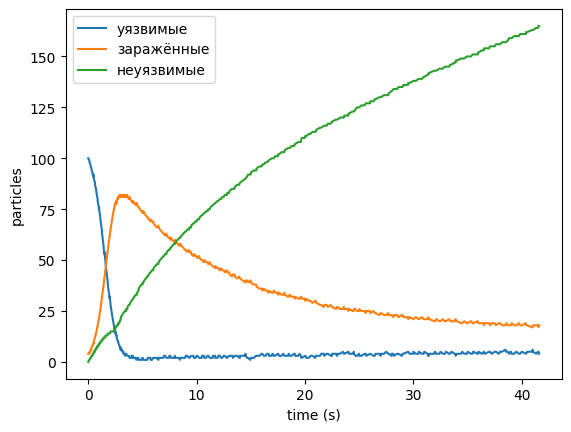

In [24]:
states = ["уязвимые", "заражённые", "неуязвимые"]
def plot_particles_history(particles_history, times):
    for i in range(n):
        plt.plot(times, particles_history[:, i], label=f"{states[i]}")
    plt.xlabel("time (s)")
    plt.ylabel("particles")
    plt.legend()
    plt.show()

plot_particles_history(particles_history, times)

### Obtaining 40 trajectories with 200 steps

In [25]:
# Фактически в общем случае получится 40 * 200 уникальных значений времени. Значит придётся
# интерполировать функции s(t), i(t), r(t) на значения времени из других траекторий, что создаст
# суммарно 40 * 200 * 3 значений в массиве состояний
k = 400
trj = 500
particles_history = np.empty((trj, k + 1, n))
times = np.empty((trj, k + 1))
particles_history[:, 0, :] = np.array([100, 4, 0])
times[:, 0] = 0

for j in range(trj):
    alpha = np.array([100, 4, 0])
    tau = np.array([0 for _ in range(l)], dtype=np.float32) # время следующего события i
    for i in range(l):
        tau[i] = inverse_exp(random.random(), phi[i])

    phi = np.array([lmb*alpha[0]*alpha[1], imm*alpha[1], imm*alpha[0], a])

    for i in range(1, k + 1):
        tau, next_event, delta_time = update_tau(tau)
        alpha, phi = taking_action(alpha, next_event)
        tau[next_event] = inverse_exp(random.random(), phi[next_event])
        particles_history[j, i, :] = alpha
        times[j, i] = delta_time + times[j, i - 1]
        if j == 0 or j == 1 or j == 2:
            print(f"after {i} step:")
            print("tau:", tau, "\nphi:", phi, "\nalpha:", alpha, "\nevent:", next_event)

after 1 step:
tau: [0.07426387 0.33906955 0.68736786 0.41392785] 
phi: [9.9 0.5 9.9 2. ] 
alpha: [99  5  0] 
event: 0
after 2 step:
tau: [0.02163882 0.26480567 0.613104   0.33966398] 
phi: [11.76  0.6   9.8   2.  ] 
alpha: [98  6  0] 
event: 0
after 3 step:
tau: [0.04892766 0.24316685 0.5914652  0.31802517] 
phi: [13.58  0.7   9.7   2.  ] 
alpha: [97  7  0] 
event: 0
after 4 step:
tau: [0.0312836 0.1942392 0.5425375 0.2690975] 
phi: [15.36  0.8   9.6   2.  ] 
alpha: [96  8  0] 
event: 0
after 5 step:
tau: [0.01443426 0.1629556  0.5112539  0.2378139 ] 
phi: [17.1  0.9  9.5  2. ] 
alpha: [95  9  0] 
event: 0
after 6 step:
tau: [0.05727659 0.14852133 0.49681962 0.22337964] 
phi: [18.8  1.   9.4  2. ] 
alpha: [94 10  0] 
event: 0
after 7 step:
tau: [0.1791956  0.09124474 0.43954304 0.16610305] 
phi: [20.46  1.1   9.3   2.  ] 
alpha: [93 11  0] 
event: 0
after 8 step:
tau: [0.08795086 0.9543886  0.3482983  0.07485831] 
phi: [18.6  1.   9.3  2. ] 
alpha: [93 10  1] 
event: 1
after 9 step:
ta

### Obtaining mean of trajectories

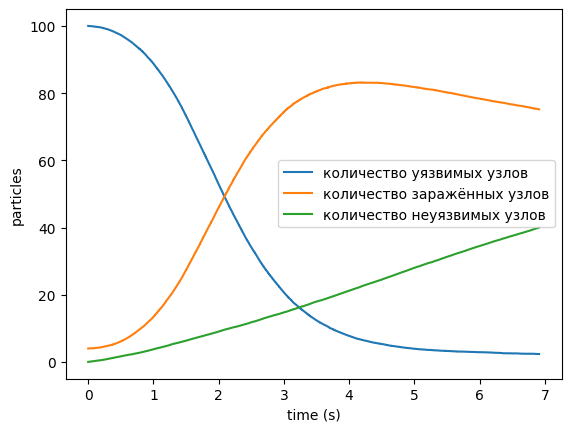

In [26]:
# Сложность алгоритма по времени O(trj^2 * (k - 2)) * O(np.mean)
# по памяти O(trj * (k - 2) * n); n - количество разных видов частиц (узлов)
indices = np.ones(trj, dtype=int)
cum_indices = np.zeros(trj, dtype=int)
merged = [np.array([100, 4, 0])]
total_times = [0]

for i in range(trj * (k - 2)):
    idx_min = np.argmin(times[np.arange(trj), indices])
    cum_indices[idx_min] = min(cum_indices[idx_min] + 1, 200)
    indices[idx_min] = min(indices[idx_min] + 1, 200)

    merged.append(np.mean(particles_history[np.arange(trj), cum_indices, :], axis=0))
    total_times.append(times[idx_min, cum_indices[idx_min]])

plt.plot(total_times, merged, label=["количество уязвимых узлов", "количество заражённых узлов", "количество неуязвимых узлов"])
plt.xlabel("time (s)")
plt.ylabel("particles")
plt.legend()
plt.show()

In [27]:
print(particles_history[[1, 2, 3], :4, :])

[[[100.   4.   0.]
  [101.   4.   0.]
  [100.   5.   0.]
  [ 99.   5.   1.]]

 [[100.   4.   0.]
  [100.   3.   1.]
  [ 99.   4.   1.]
  [100.   4.   1.]]

 [[100.   4.   0.]
  [101.   4.   0.]
  [102.   4.   0.]
  [102.   3.   1.]]]
